In [49]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth # Algorítmo para mineiração de dados
from pyspark.sql import SQLContext # Converter o DF pandas e DF SPark
from pyspark.sql.functions import col, round
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer # Preparação específica dos dados
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # Avaliar o modelo
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [50]:
# Carregando os Dados

In [51]:
dados = pd.read_csv("C:/Projetos Pessoais/DataScience/dados/supllyChain/DataCoSupplyChainDataset.csv", encoding= 'latin1')

In [52]:
dados.shape

(180519, 53)

In [53]:
# amostra
dados.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [54]:
dados.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [55]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [56]:
# Verifica valores ausentes 
dados.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [57]:
# Criando nova coluna para o nome do cliente adicionando colunas de nome e sobrenome do cliente
dados['Customer Name'] = dados['Customer Fname'].astype(str) + dados['Customer Lname'].astype(str)

In [58]:
# Removendo colunas que parecem não ser necessárias 
dados = dados.drop(['Product Status',
                    'Customer Password',
                    'Customer Email',
                    'Customer Street',
                    'Customer Fname',
                    'Customer Lname',
                    'Latitude',
                    'Longitude',
                    'Product Description',
                    'Order Zipcode',
                    'shipping date (DateOrders)'],
                    axis = 1)

In [59]:
dados.sample(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Image,Product Name,Product Price,Shipping Mode,Customer Name
29888,PAYMENT,5,2,-107.790001,195.979996,Late delivery,1,9,Cardio Equipment,San Diego,...,Central America,Quezaltenango,PENDING_PAYMENT,191,9,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,Second Class,MaryLee
52894,DEBIT,5,4,45.500000,181.990005,Late delivery,1,48,Water Sports,Hollywood,...,Western Europe,Norte-Paso de Calais-Picardía,COMPLETE,1073,48,http://images.acmesports.sports/Pelican+Sunstr...,Pelican Sunstream 100 Kayak,199.990005,Standard Class,AndrewMarshall
18231,CASH,4,2,9.070000,120.889999,Late delivery,1,18,Men's Footwear,Brooklyn,...,West of USA,Oregón,CLOSED,403,18,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Second Class,MaryWilson
132961,DEBIT,4,4,-277.089996,167.929993,Shipping on time,0,46,Indoor/Outdoor Games,Caguas,...,South Asia,Assam,ON_HOLD,1014,46,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class,RichardSmith
113288,PAYMENT,2,1,107.959999,224.910004,Late delivery,1,46,Indoor/Outdoor Games,Caguas,...,West Asia,Adiyaman,PENDING_PAYMENT,1014,46,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,First Class,RonaldMcneil


In [60]:
# Atribuindo zero aos valores ausentes 
dados['Customer Zipcode'] = dados['Customer Zipcode'].fillna(0)

In [61]:
# Tipos de dados 
dados.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
order date (DateOrders)           object
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Disco

In [62]:
# vERIFICANDO 

In [63]:
# VENDAS POR REGIÃO 
grupo_mercado = dados.groupby('Market')

<Axes: title={'center': ' Vendas Por Continente '}, xlabel='Market'>

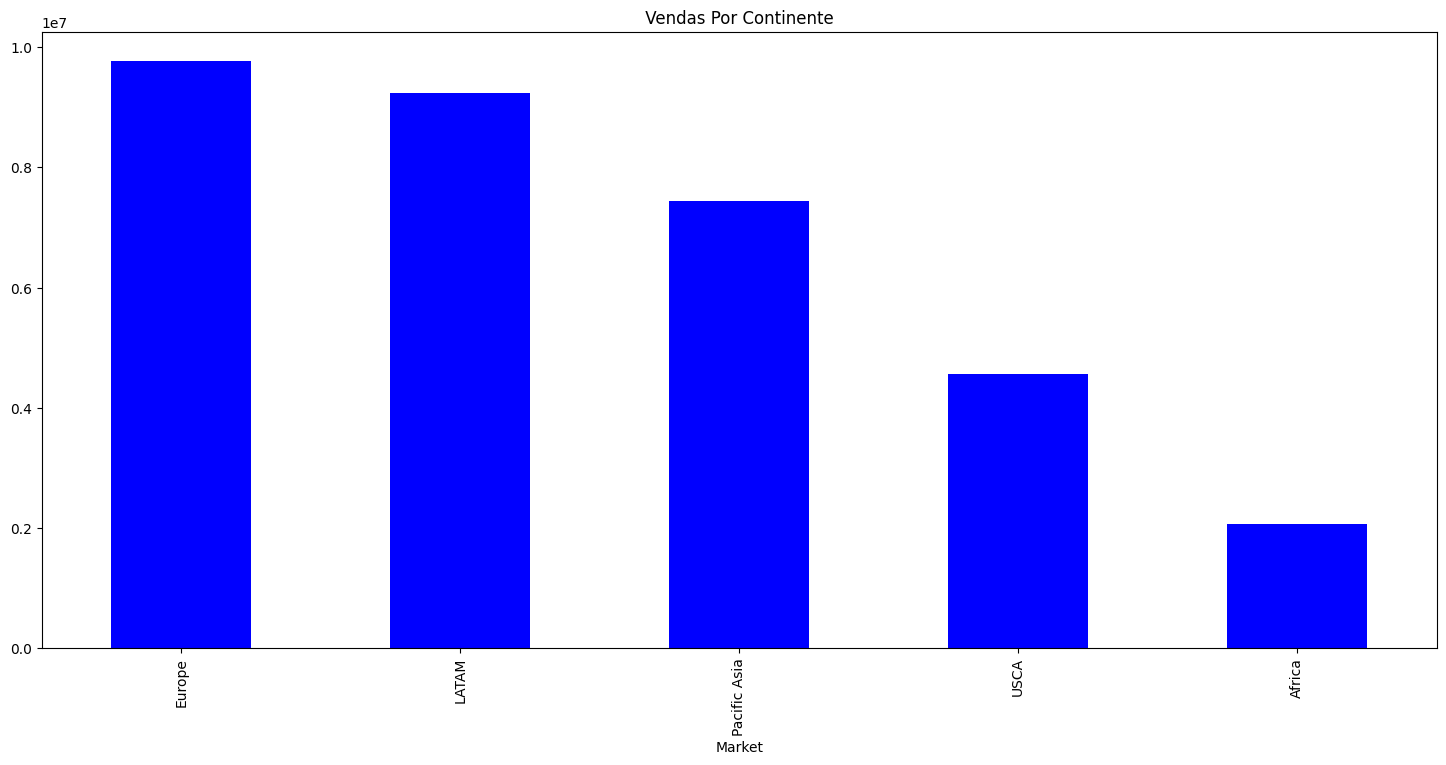

In [64]:
# PLot
plt.figure(1)
grupo_mercado['Sales per customer'].sum().sort_values(ascending= False).plot.bar(figsize = (18,8),
                                                                                 color = ['blue'],
                                                                                 title = " Vendas Por Continente ")

Pode-se obsrvar que a empresa tem maior número de vendas na europa, em detrimento a Africa

In [65]:
# Agrupando por Order Region
grupo_regiao = dados.groupby('Order Region')

<Axes: title={'center': ' Vendas Por Continente '}, xlabel='Order Region'>

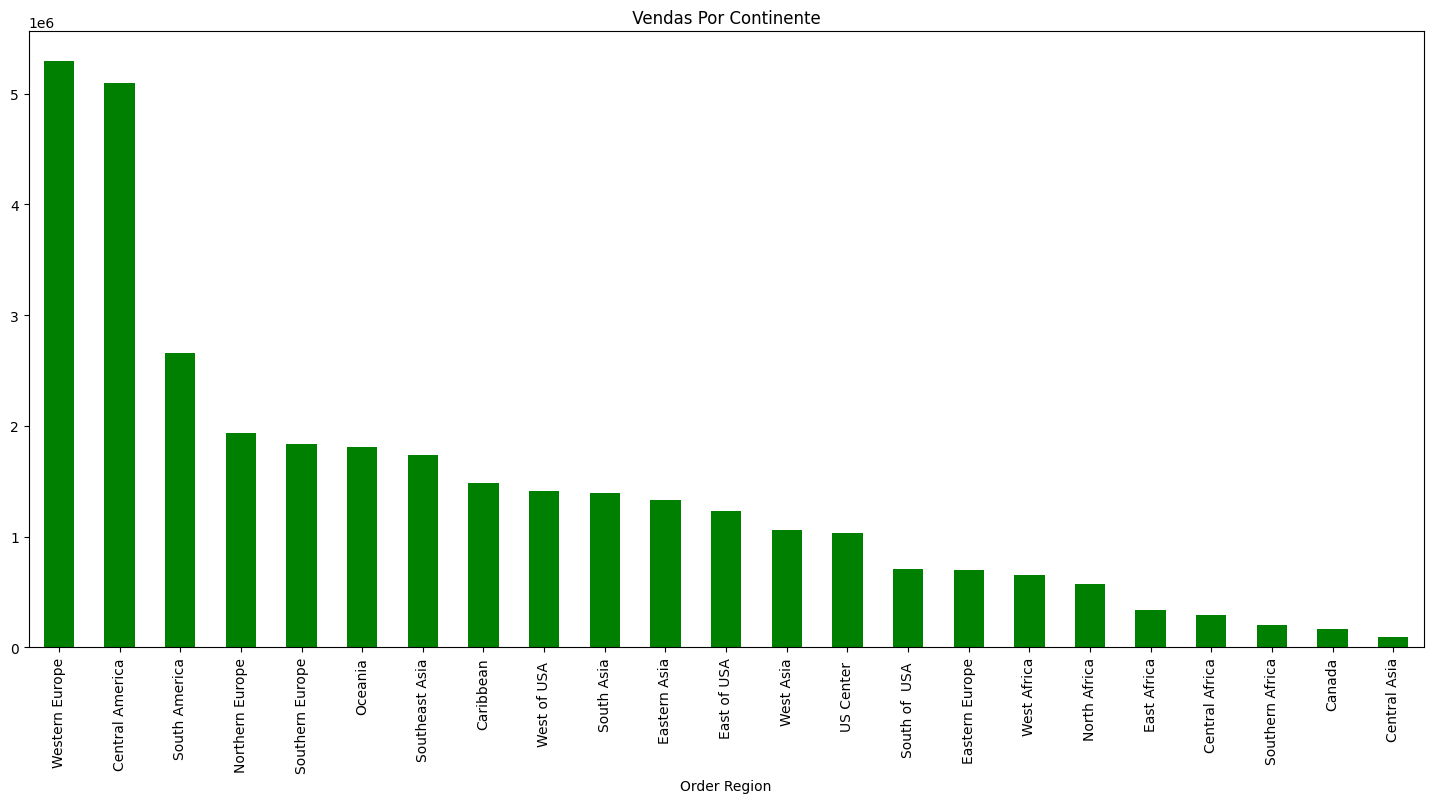

In [66]:
# PLot
plt.figure(2)
grupo_regiao['Sales per customer'].sum().sort_values(ascending= False).plot.bar(figsize = (18,8),
                                                                                 color = ['green'],
                                                                                 title = " Vendas Por Continente ")

In [67]:
# Vendas por Produto 
categoria = dados.groupby('Category Name')

<Axes: title={'center': 'Vendas por categoria de Produto'}, xlabel='Category Name'>

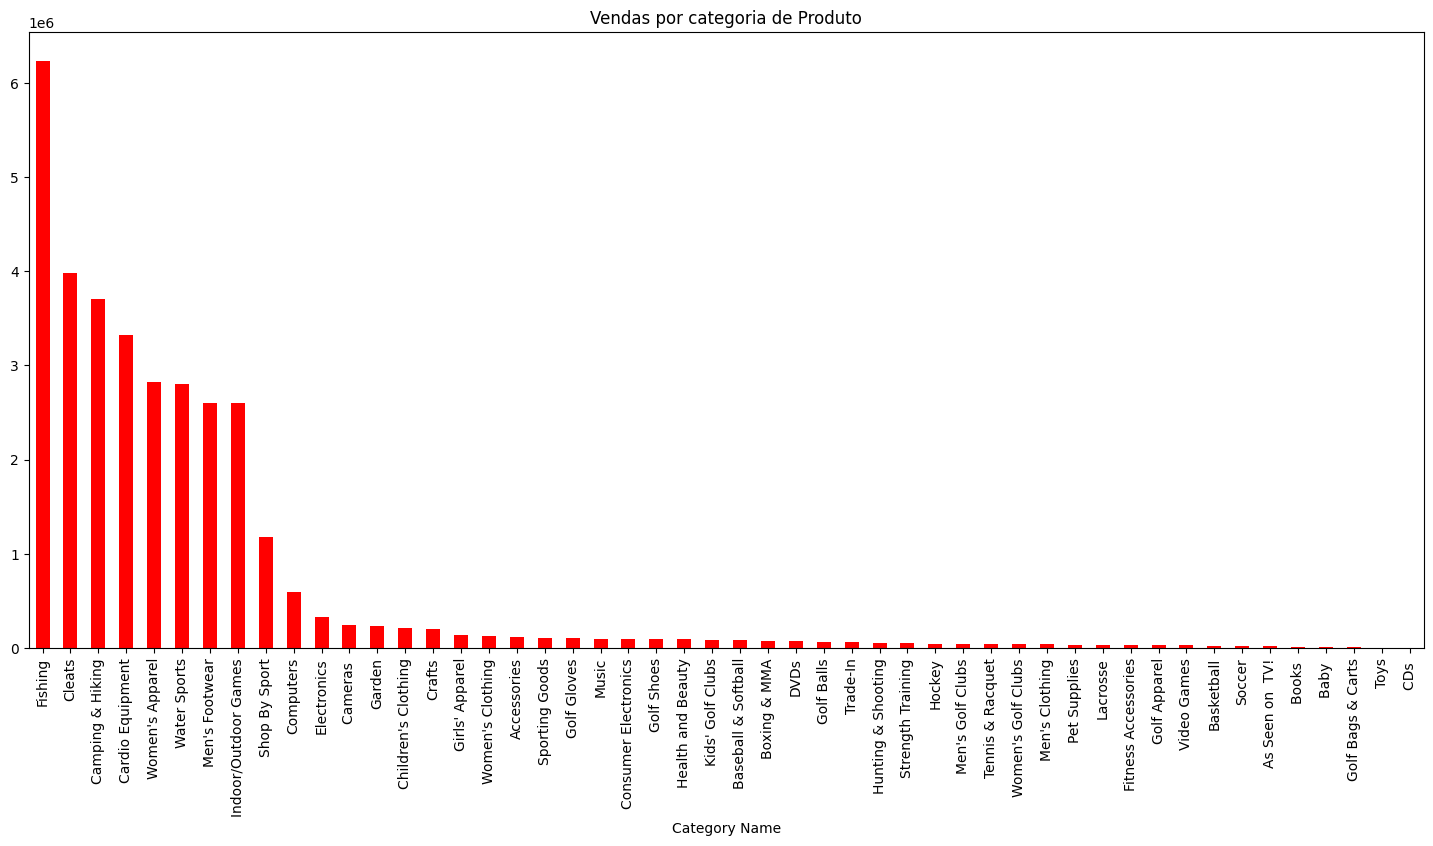

In [68]:
# PLot
plt.figure(2)
categoria['Sales per customer'].sum().sort_values(ascending= False).plot.bar(figsize = (18,8),
                                                                                 color = ['red'],
                                                                                 title = "Vendas por categoria de Produto")

<Axes: title={'center': 'Vendas por categoria de Produto'}, xlabel='Category Name'>

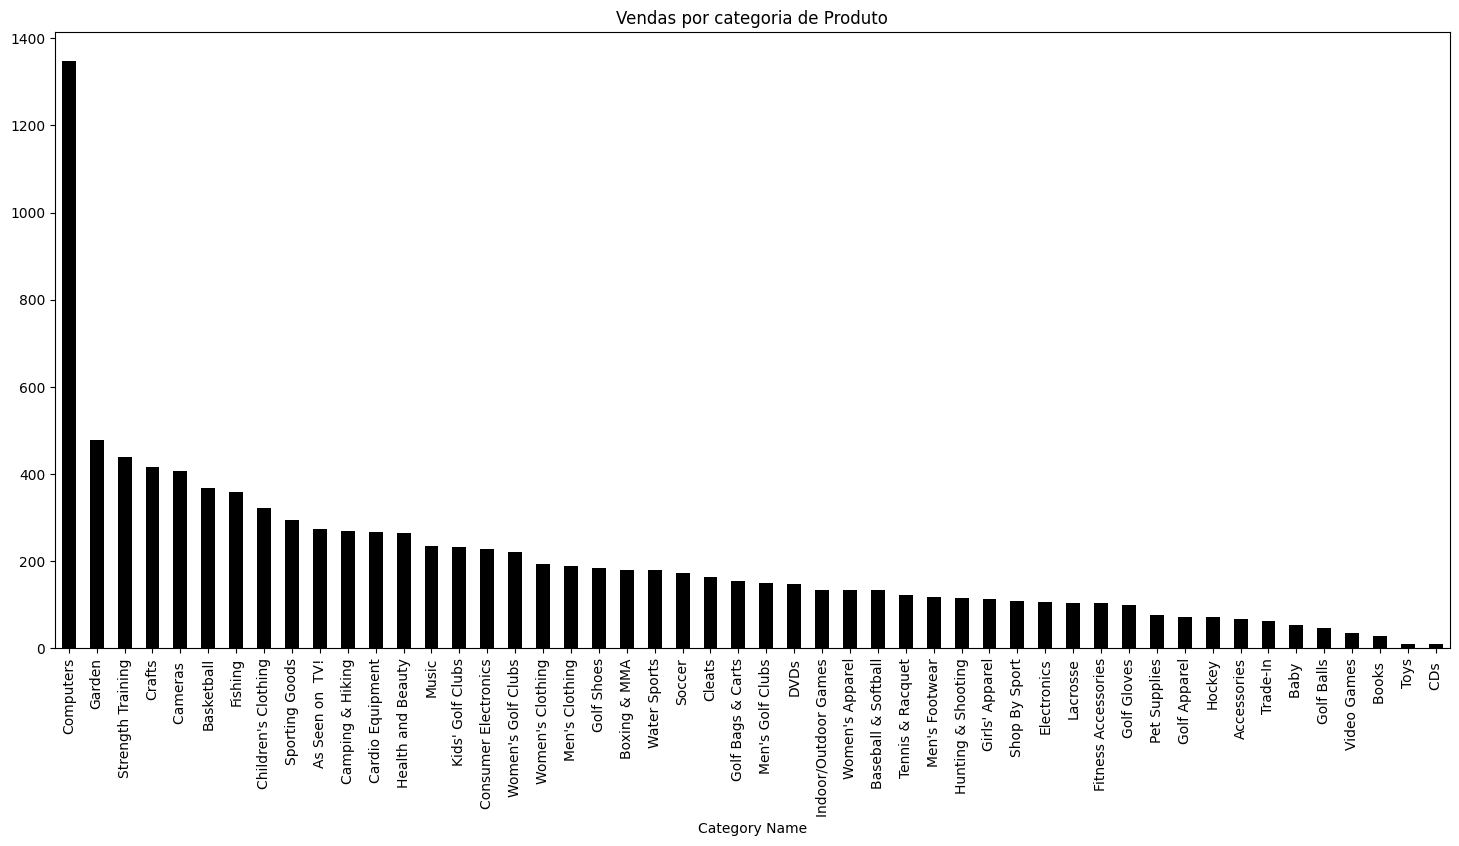

In [69]:
# PLot
plt.figure(2)
categoria['Sales per customer'].mean().sort_values(ascending= False).plot.bar(figsize = (18,8),
                                                                                 color = ['black'],
                                                                                 title = "Vendas por categoria de Produto")

<Axes: title={'center': 'Vendas por categoria de Produto'}, xlabel='Category Name'>

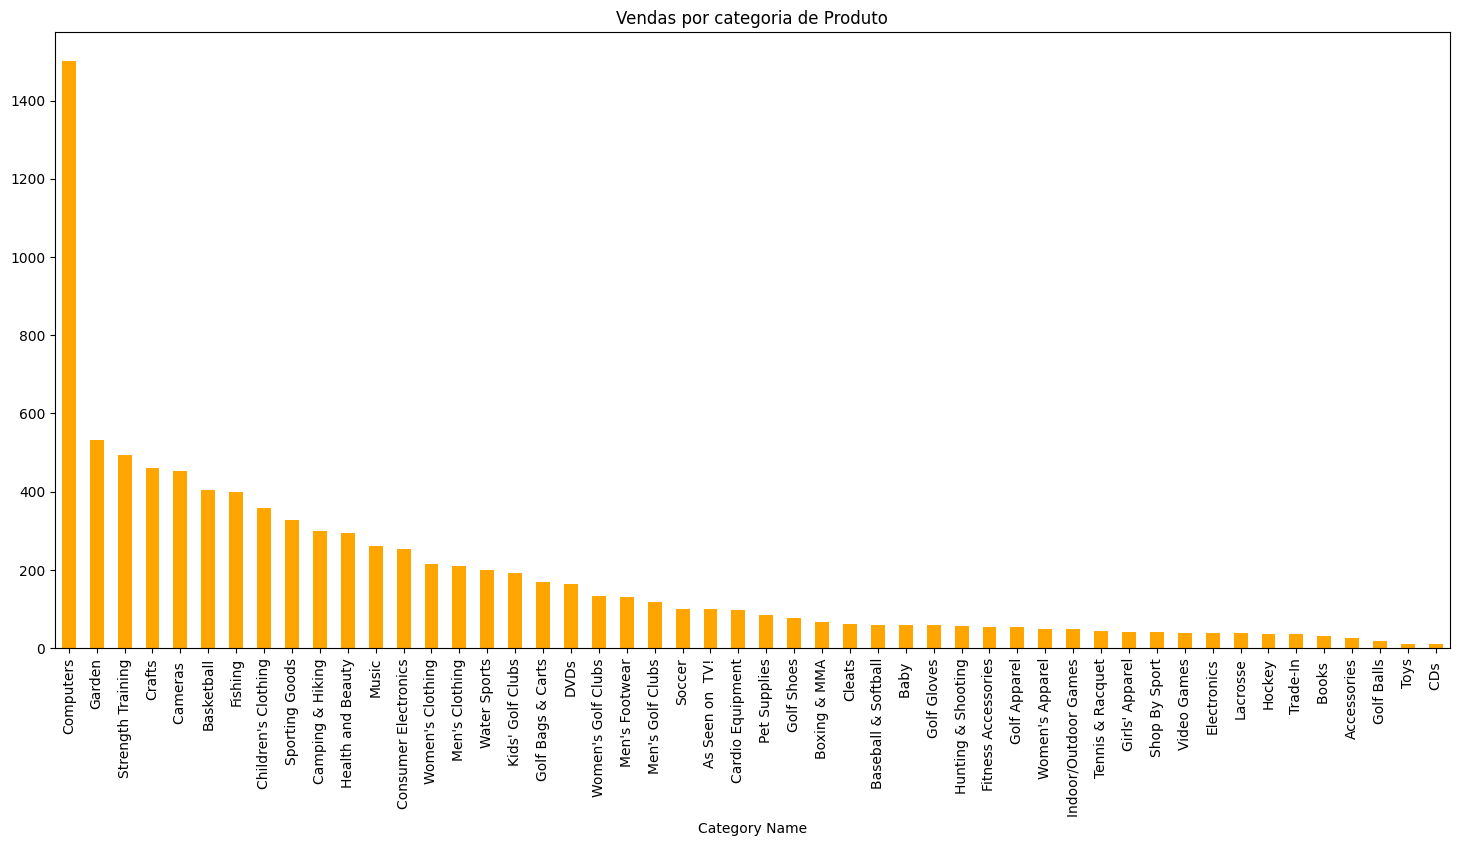

In [70]:
# PREÇO MÉDIO DE VENDAS POR CATEGORIA 
# PLot
plt.figure(2)
categoria['Product Price'].mean().sort_values(ascending= False).plot.bar(figsize = (18,8),
                                                                                 color = ['Orange'],
                                                                                 title = "Vendas por categoria de Produto")

Os produtos com preços mais altos, possuem maior média de volume de vendas. os computadores vendem cerca de 1.400 unidades, apesar do peço médio ser 1500

- Qual será relação entre o preço do produto e unidades vendidas? vamos descobrir

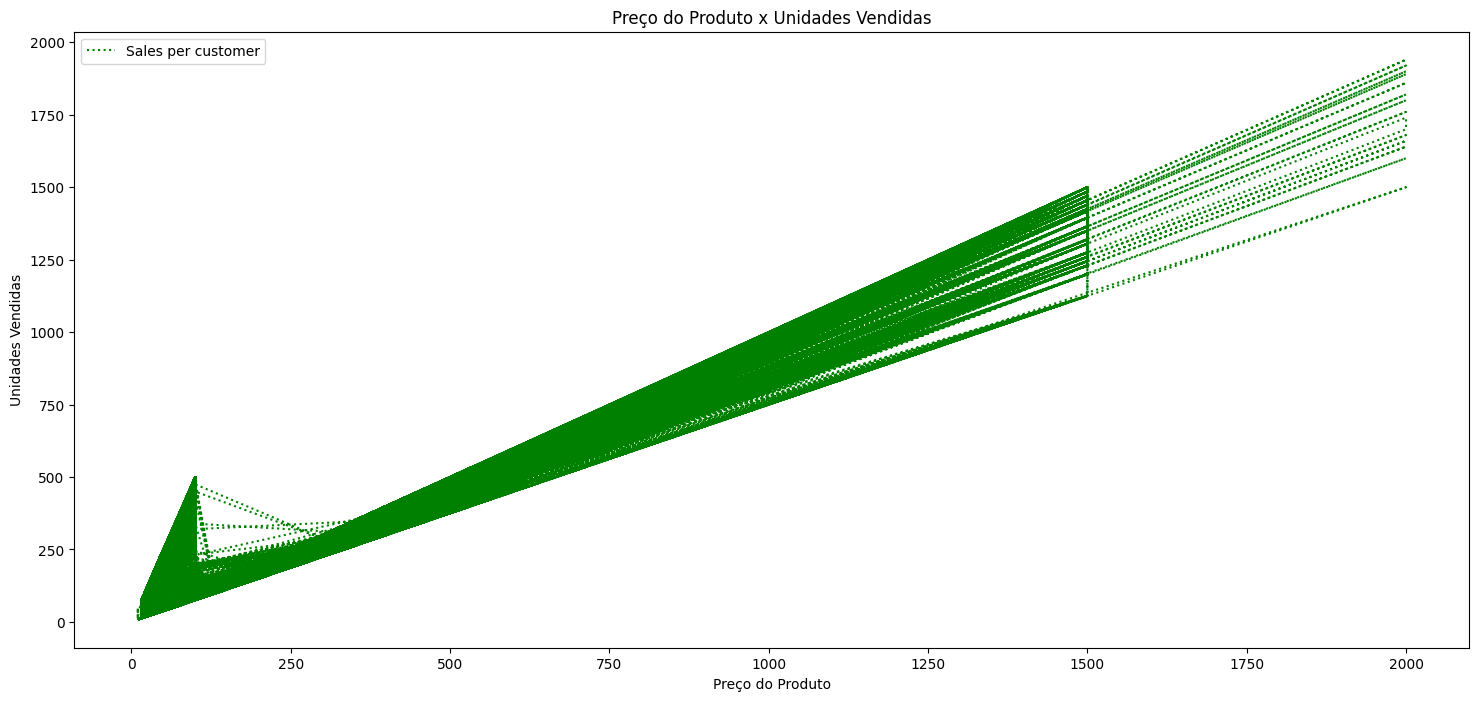

In [71]:
# Relação entre preço do produto x unidades vendidas

dados.plot(x = "Product Price",
           y = "Sales per customer",
           linestyle = "dotted",
           markerfacecolor = "blue",
           markersize = 12,
           color = ['green'],
           figsize = (18,8))
plt.title('Preço do Produto x Unidades Vendidas')
plt.xlabel("Preço do Produto")
plt.ylabel("Unidades Vendidas")
plt.show()

Podemos ver que existe uma relação linear entre aumento de preço e colume de vendas

In [72]:
# Salvando os dados 

dados.to_csv("C:/Projetos Pessoais/DataScience/dados/supllyChain/dataCoSupplyChainDatasetPROCESSADOS.csv")

# ETAPA 2  -  REGRAS DE ASSOCIAÇÃO 

As Regras de Associação representam um dos conceitos mais importantes de aprendizado de máquina, usado principalmente na análise de cesta de compras. Ou seja, precisamos de dados de vendas de produtos

Em uma loja (ou portal de e0commerce), todos os vegetais são colocados no mesmo corredor, todos os laticinios são colocados juntos e os comséticos formaum outro conjunto desses grupos.

Investir tempo e recursos em pposicionamento deliberados de produtosm não apenas reduz o tempo de compra do cliente, mas também lembra o cliente de quais itens relevantes ele pode estar interessado em comprar, ajudando assim as lojas as fazerem vendas cruzadas no processo. Outra vantagem é na cadeia de suprimentos, pois os sistemas de entrega podem ser adaptadaso e personalizados ao padrão de compra dos clientes.

As Regras de Associação ajudam a descobrir todas as relções entre itens de bancos de dados imensos. Uma coisa importante a se notar é que as Regras de associação não extraem a preferência de um indviduo, em vez disso, encontram relações entre um conjunto de elementos de cada transação distinta. Isso é o que os torna diferetentes da filtragem colaborativa, por exemplo! 

In [73]:
# Carreganod novamente o conjunto de dados limpos

dados = pd.read_csv("C:/Projetos Pessoais/DataScience/dados/supllyChain/dataCoSupplyChainDatasetPROCESSADOS.csv", encoding='latin1')

In [74]:
# Visualizando
dados.sample(5)

,Unnamed: 0,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,...,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Image,Product Name,Product Price,Shipping Mode,Customer Name
133339,133339,PAYMENT,2,4,65.519997,142.440002,Advance shipping,0,46,Indoor/Outdoor Games,...,South Asia,Punyab,PENDING_PAYMENT,1014,46,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class,JuliaBeck
59161,59161,PAYMENT,2,1,29.570000,86.970001,Late delivery,1,5,Lacrosse,...,West Asia,BingÃ¶l,PENDING_PAYMENT,93,5,http://images.acmesports.sports/Under+Armour+M...,Under Armour Men's Tech II T-Shirt,24.990000,First Class,RuthSmith
78852,78852,PAYMENT,4,4,66.239998,195.990005,Shipping on time,0,48,Water Sports,...,West of USA,California,PENDING_PAYMENT,1073,48,http://images.acmesports.sports/Pelican+Sunstr...,Pelican Sunstream 100 Kayak,199.990005,Standard Class,MarySmith
3473,3473,DEBIT,6,2,8.110000,128.690002,Late delivery,1,18,Men's Footwear,...,Central America,Baja California,ON_HOLD,403,18,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Second Class,MarySmith
175848,175848,DEBIT,2,1,39.160000,107.889999,Late delivery,1,18,Men's Footwear,...,US Center,Oklahoma,ON_HOLD,403,18,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,First Class,CatherineSpence


In [75]:
# Clientes únicos
dados['Customer Name'].unique()

array(['CallyHolloway', 'IreneLuna', 'GillianMaldonado', ...,
       'AnikaDavenport', 'YuriSmith', 'HyacinthWitt'], dtype=object)

In [76]:
# VAMOS ENTÃO ASSOCIAR CLIENTES E PRODUTOS ( COLOCAR COMO LISTA OS PRODUTOS)

df = dados.copy()
df = df[['Customer Name', 'Product Name']]
df = df.drop_duplicates(['Customer Name', 'Product Name'])
df = df.groupby('Customer Name')['Product Name'].apply(list).reset_index(name = 'Products')

In [77]:
df.head()

,Customer Name,Products
0,AaronBerger,[Under Armour Girls' Toddler Spine Surge Runni...
1,AaronBoyle,[Diamondback Women's Serene Classic Comfort Bi...
2,AaronBush,"[Nike Men's CJ Elite 2 TD Football Cleat, Unde..."
3,AaronCalhoun,"[Perfect Fitness Perfect Rip Deck, Pelican Sun..."
4,AaronCarr,"[Pelican Sunstream 100 Kayak, Nike Men's CJ El..."


#### Vamos converter o dataframe pandas para dataframe Spark

In [78]:
# Cria sessão Spark

spark = SparkSession.builder.master("local").appName("DSA").config('spark.ui.port', '4050').getOrCreate()

# master - primeiro servidor do cluster spark, ou seja, o local
# porta 4050 caso queira acompanha no navegador

In [79]:
# Sessão SPARK
spark

In [86]:
# Criando o SQL Context
sqlContext = SQLContext(spark)

c:\Users\alyss\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [87]:
df_spark_frame = sqlContext.createDataFrame(df)

AttributeError: 'SparkSession' object has no attribute 'parallelize'

In [85]:
type(df_spark_frame)

pyspark.sql.dataframe.DataFrame

In [42]:
df_spark_frame

DataFrame[Customer Name: string, Products: array<string>]

In [43]:
df_spark_frame.show(5)

Py4JJavaError: An error occurred while calling o58.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2.0 (TID 2) (Skylerfox executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:170)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.io.IOException: CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:499)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4177)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3382)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:284)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:323)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:170)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:499)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 32 more


## APLICANDO O ALGORÍTMO FREQUENT PATTERN MINING

- Mineiração de termos/padrões frequentes

In [45]:
# Cria o objeto fpGrowth instanciando o construtor FPGrowth com os parâmetros necessários
fpGrowth = FPGrowth(itemsCol= "Products", minSupport= 0.015, minConfidence= 0.35)

In [48]:
# Ajusta o dataframe no objeto fpGrowth com os parâmetros necessários
modelo = fpGrowth.fit(df_spark_frame)

Py4JJavaError: An error occurred while calling o77.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5.0 failed 1 times, most recent failure: Lost task 0.0 in stage 5.0 (TID 5) (Skylerfox executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:170)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:377)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.io.IOException: CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:499)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 49 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1266)
	at org.apache.spark.ml.fpm.FPGrowth.$anonfun$genericFit$1(FPGrowth.scala:178)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.fpm.FPGrowth.genericFit(FPGrowth.scala:162)
	at org.apache.spark.ml.fpm.FPGrowth.fit(FPGrowth.scala:159)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1143)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1073)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:170)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:377)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, O sistema não pode encontrar o arquivo especificado
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:499)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:158)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1110)
	... 49 more
